In [1]:
from rdkit import Chem
from rdkit.Chem import Descriptors

import numpy as np
import pandas as pd
import math

from mordred import Calculator, descriptors

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sb

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import root_mean_squared_error,r2_score,mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso

from tqdm import tqdm

random_seed = 4568

# Load data and calculate descriptors

In [2]:
df = pd.read_csv('../data/crc_2.csv', sep=';')

In [3]:
df = df[['SMILES', 'IUPAC_name', 'delta_bp']].copy()

In [4]:
df['Mol'] = df['SMILES'].apply(Chem.MolFromSmiles)

In [5]:
calc = Calculator(descriptors, ignore_3D=True)
def calculate_descriptors(mol):
    desc_values = calc(mol)
    desc_dict = {}
    
    for d, v in desc_values.items():
        try:
            value = float(v)
            # Check for NaN or infinity (overflow issues)
            if np.isfinite(value):
                desc_dict[str(d)] = value
            else: # Replace with NaN
                desc_dict[str(d)] = np.nan
                
        # Replace errors with NaN
        except (ValueError, OverflowError, TypeError):
            desc_dict[str(d)] = np.nan
    
    return desc_dict

In [6]:
df_desc = df['Mol'].apply(calculate_descriptors).apply(pd.Series)
nan_columns = df_desc.columns[df_desc.isna().all()].tolist()
# print('Number of NaN columns: ', len(nan_columns))
df_desc = df_desc.drop(columns=nan_columns)
# print(nan_columns)
some_nan_columns = df_desc.columns[df_desc.isna().any()].tolist()
# print(len(some_nan_columns))
# print(some_nan_columns)
df_desc = df_desc.drop(columns=some_nan_columns)
const_cols = [col for col in df_desc.columns if df_desc[col].nunique() == 1]
# print(len(const_cols))
# print(const_cols)
df_desc = df_desc.drop(columns=const_cols)

C:\Users\barca\miniconda3\envs\BP\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [7]:
df = pd.concat([df, df_desc], axis=1)

In [8]:
df.head(2)

,SMILES,IUPAC_name,delta_bp,Mol,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,CCCC,butane,0.0,<rdkit.Chem.rdchem.Mol object at 0x000002224BF...,4.472136,1.618034,3.236068,4.472136,1.118034,2.155909,...,5.509388,22.328143,58.078250,4.148446,10.0,1.0,10.0,8.0,2.5,1.25
1,CCCCCCCCCCCC,dodecane,0.0,<rdkit.Chem.rdchem.Mol object at 0x000002224BF...,14.592460,1.941884,3.883767,14.592460,1.216038,3.291100,...,7.720018,38.766486,170.203451,4.479038,286.0,9.0,42.0,40.0,4.5,3.25


In [47]:
df['num_atoms'] = df.Mol.apply(lambda mol: mol.GetNumAtoms())
df_branched = df[df["SMILES"].str.contains(r"\(")]

In [52]:
df_no_outliers = df_branched[df_branched['delta_bp'] < 125]
df_no_outliers = df_no_outliers[df_no_outliers['WPath'] < 3500]

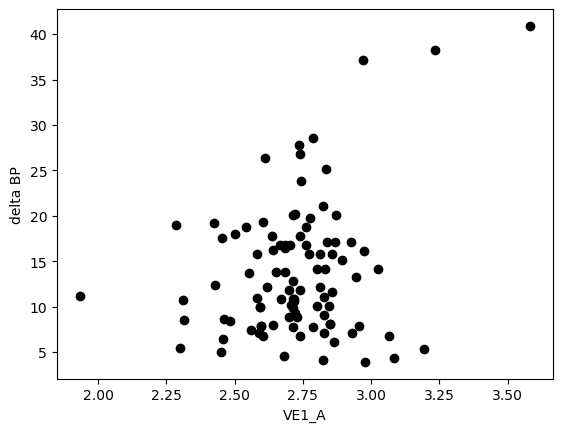

In [57]:
plt.scatter(df_no_outliers.VE1_A, df_no_outliers.delta_bp, color='black', label='W_log', marker='o')
plt.xlabel("VE1_A")
plt.ylabel("delta BP")
plt.show()

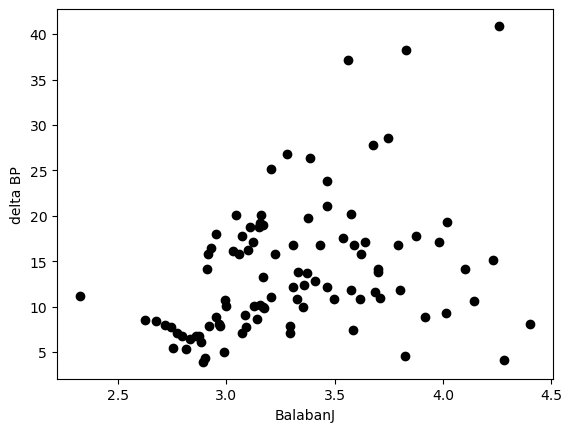

In [58]:
plt.scatter(df_no_outliers.BalabanJ, df_no_outliers.delta_bp, color='black', label='W_log', marker='o')
plt.xlabel("BalabanJ")
plt.ylabel("delta BP")
plt.show()

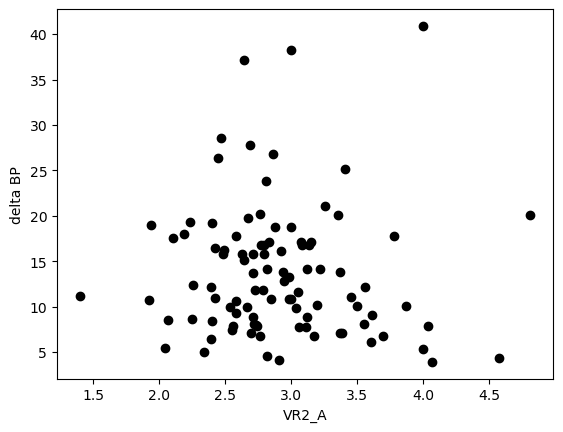

In [59]:
plt.scatter(df_no_outliers.VR2_A, df_no_outliers.delta_bp, color='black', label='W_log', marker='o')
plt.xlabel("VR2_A")
plt.ylabel("delta BP")
plt.show()

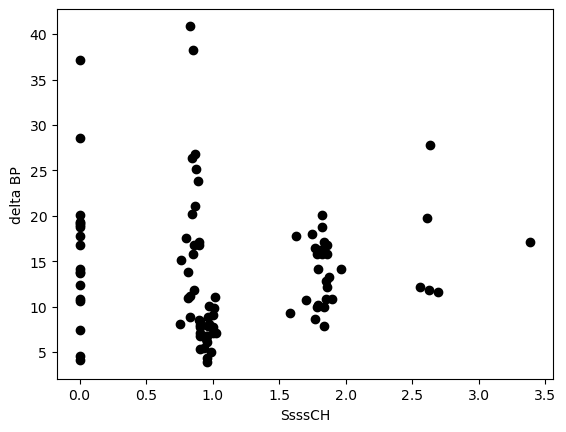

In [60]:
plt.scatter(df_no_outliers.SsssCH, df_no_outliers.delta_bp, color='black', label='W_log', marker='o')
plt.xlabel("SsssCH")
plt.ylabel("delta BP")
plt.show()

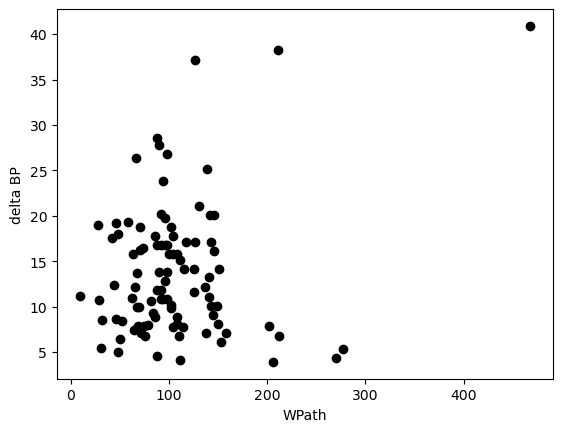

In [61]:
plt.scatter(df_no_outliers.WPath, df_no_outliers.delta_bp, color='black', label='W_log', marker='o')
plt.xlabel("WPath")
plt.ylabel("delta BP")
plt.show()

In [56]:
(df_branched[df_branched['delta_bp'] > 125])[['SMILES', 'IUPAC_name', 'delta_bp', 'num_atoms']]

,SMILES,IUPAC_name,delta_bp,num_atoms
4,CCCCCCCCCCCCCCCCCC(CCCC)CCCC,5-butyldocosane,171.0,26
5,CCCCCCCCCCCC(CCCC)CCCCCCCCCC,11-butyldocosane,172.5,26
6,CCCCCCCCCCC(CCCCCCCCCC)CCCCCCCCCC,11-decylhenicosane,176.0,31


In [55]:
(df_branched[df_branched['WPath'] > 3500])[['SMILES', 'IUPAC_name', 'delta_bp', 'num_atoms']]

,SMILES,IUPAC_name,delta_bp,num_atoms
6,CCCCCCCCCCC(CCCCCCCCCC)CCCCCCCCCC,11-decylhenicosane,176.0,31
65,CC(C)CCCC(C)CCCC(C)CCCCC(C)CCCC(C)CCCC(C)C,"2,6,10,15,19,23-hexamethyltetracosane",31.0,30
